## 1. Importing Dependencies and Initial Setup

In [1]:
# Handling class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Utilities for storage and logging
import joblib
import logging
import os
from pathlib import Path
import pickle

# Data handling and computation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine learning models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Model preprocessing, selection and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve,
    precision_recall_curve, 
    auc,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# Display plots inline to jupyter notebook
%matplotlib inline

# Paths
datapath = Path("../data/telco_customer_churn.csv") # Dataset path
model_dump = Path("../model/model_dump.joblib")     # Trained model storage
encoder_dump = Path("../model/encoder_dump.pkl")    # Label encoder storage
state_dump = Path("../model/state_dump.pkl")        # Application state storage

# Pandas display options
pd.set_option("display.max_columns", None)
pd.set_option('display.expand_frame_repr', False)

# Logging
logging.basicConfig(
    level = logging.INFO,       # For verbose logging
    # level = logging.ERROR     # For logging only errors
    format = "%(levelname)s: %(message)s"
)

# Fix random seed for reproducibility
np.random.seed(42)

# Creating model directory if not exists
try:
    os.makedirs("../model")
except FileExistsError:
    logging.warning("The existing files from previous model will be overwritten")

# Initialize dictionary to store application-wide state
state_holder = dict()
logging.info("Initial Setup Process Complete")

INFO: Initial Setup Process Complete


## 2. Dataset Fetch

In [2]:
try:
    # Loading dataset twice, one for model training and other preserved for application state 
    df = pd.read_csv(datapath)
    df1 = pd.read_csv(datapath)

    # Convert TotalCharges to numeric, invalid values are coerced to NaN and filled
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce').fillna(0)

    # Convert SeniorCitizen from numeric to categorical labels 
    df['SeniorCitizen'] = df['SeniorCitizen'].map({1: "Yes", 0: "No"})
    
    df = df.drop("customerID", axis = 1)

    df1['TotalCharges'] = pd.to_numeric(df1['TotalCharges'], errors='coerce').fillna(0)
    df1['SeniorCitizen'] = df1['SeniorCitizen'].map({1: "Yes", 0: "No"})

    # Store dataset and feature list for application usage
    state_holder["dataframe"] = df1
    state_holder["feature_list"] = df1.columns
    
except FileNotFoundError:
    logging.error("Dataset is not found, please check the dataset path and try again")
    raise
except Exception as e:
    logging.error(f"Failed to load dataset {e}")
finally:
    if "df" in locals():
        logging.info(f"Dataset shape received: {df.shape}")
    logging.info("Dataset loading process completed")

INFO: Dataset shape received: (7043, 20)
INFO: Dataset loading process completed


## 3. Dataset Analysis

Showing first 5 rows of the dataset

In [3]:
df.head(n = 5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Showing the dataset columns

In [4]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Showing columns and unique values in each column

In [5]:
categorical_cols = df.select_dtypes(include = "object").columns.to_list()

categorical_info = pd.DataFrame({
    "Column": categorical_cols,
    "Unique_Values": [df[i].unique() for i in categorical_cols],
    "Unique_Count": [df[i].nunique() for i in categorical_cols]
})

categorical_info

,Column,Unique_Values,Unique_Count
0,gender,"[Female, Male]",2
1,SeniorCitizen,"[No, Yes]",2
2,Partner,"[Yes, No]",2
3,Dependents,"[No, Yes]",2
4,PhoneService,"[No, Yes]",2
5,MultipleLines,"[No phone service, No, Yes]",3
6,InternetService,"[DSL, Fiber optic, No]",3
7,OnlineSecurity,"[No, Yes, No internet service]",3
8,OnlineBackup,"[Yes, No, No internet service]",3
9,DeviceProtection,"[No, Yes, No internet service]",3


Distribution of class in target values (churn column)

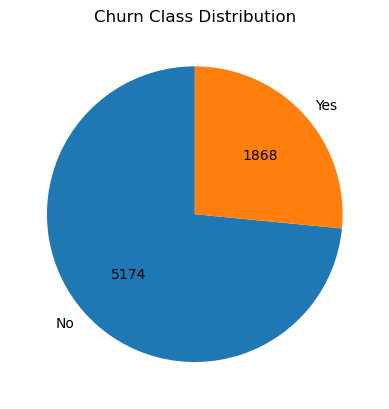

In [6]:
a = df['Churn'].value_counts()
plt.pie(
    x = a,
    labels = a.index,
    autopct = lambda p: f'{int(p*sum(a)/100)}',
    startangle = 90
)
plt.title("Churn Class Distribution")
plt.show()

Insights

1. Customer ID has been removed as it is not a useful feature for training our model.
2. Class imbalance identified in the target column.

## 4. Exploratory Data Analysis (EDA)

Showing descriptive Statistical Analysis

In [7]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


## 5. Numerical Features Analysis

Histogram plot of Numerical Features

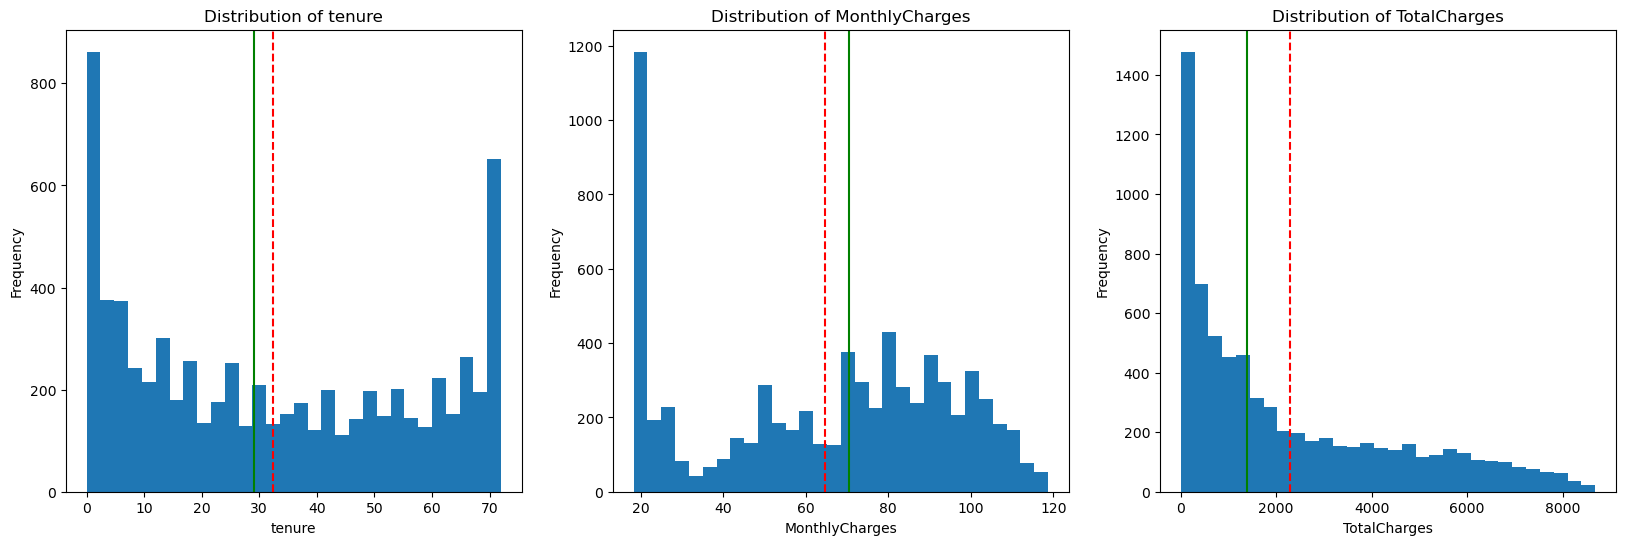

In [8]:
def plot_hist(ax, df: pd.DataFrame, column_name: str):
    ax.hist(df[column_name], bins = 30)
    ax.set_title(f"Distribution of {column_name}")
    ax.set_xlabel(column_name)
    ax.set_ylabel("Frequency")
    ax.axvline(df[column_name].mean(), color = "red", linestyle = "--", label = "Mean")
    ax.axvline(df[column_name].median(), color = "green", linestyle = "-", label = "Median")

fig, ax = plt.subplots(1, 3, figsize = (20, 6))
plot_hist(ax[0], df, "tenure")
plot_hist(ax[1], df, "MonthlyCharges")
plot_hist(ax[2], df, "TotalCharges")

Box plot of Numerical Features

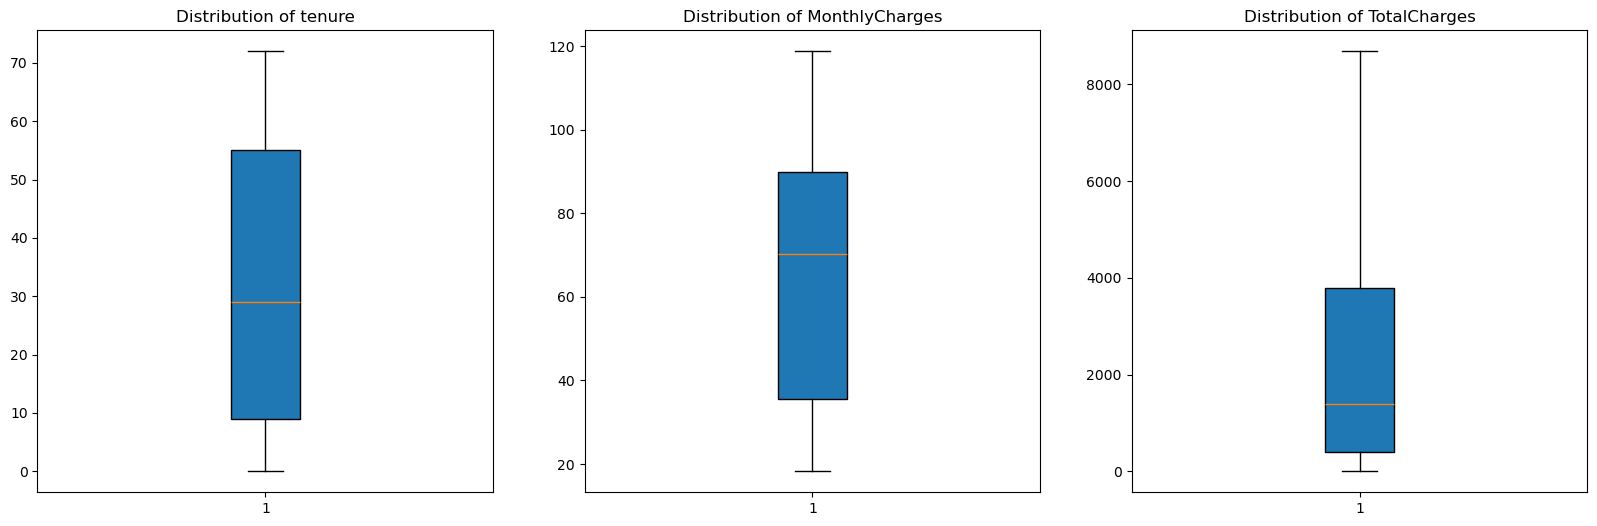

In [9]:
def plot_box(ax, df: pd.DataFrame, column_name: str):
    ax.boxplot(df[column_name], patch_artist = True)
    ax.set_title(f"Distribution of {column_name}")

fig, ax = plt.subplots(1, 3, figsize = (20, 6))
plot_box(ax[0], df, "tenure")
plot_box(ax[1], df, "MonthlyCharges")
plot_box(ax[2], df, "TotalCharges")

Correlation features of Numerical Features

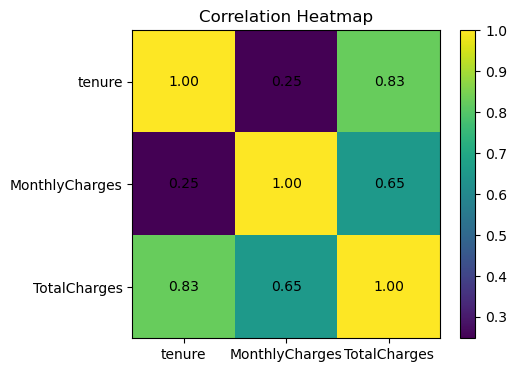

In [10]:
corr = df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()

plt.figure(figsize = (5,4))
im = plt.imshow(corr)
plt.colorbar(im)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(
            x = j, 
            y = i,
            s = f'{corr.iloc[i, j]:.2f}',
            ha = 'center',
            va = 'center',
            color = 'black'
        )
plt.title("Correlation Heatmap")
plt.show()

## 6. Categorical Feature Analysis

In [11]:
categorical_cols = df.select_dtypes(include = "object").columns.to_list()

Count plot for Categorical Columns

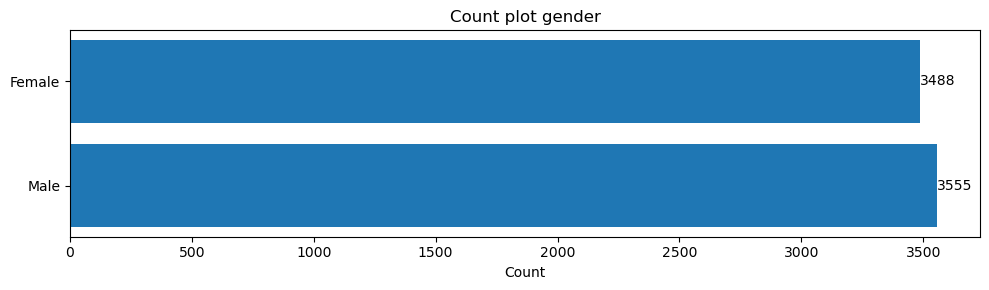

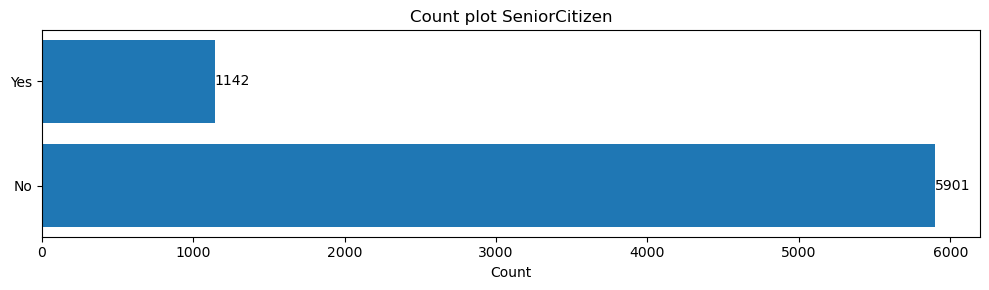

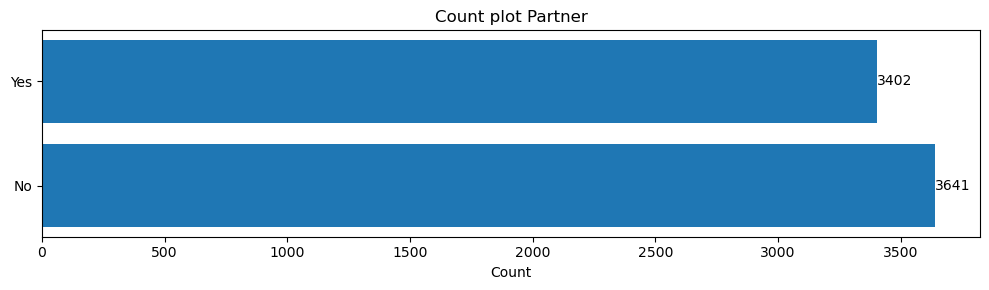

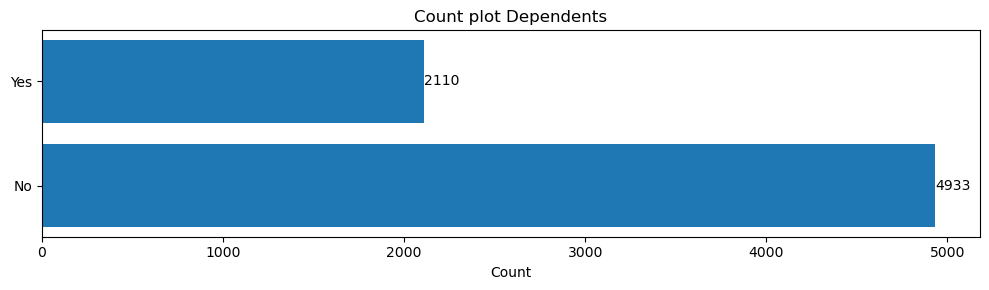

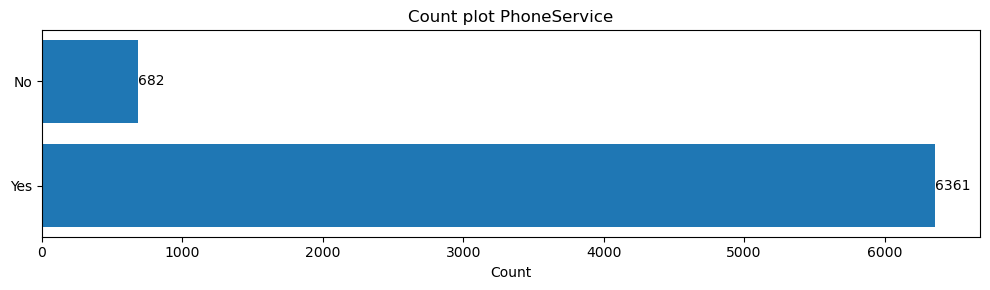

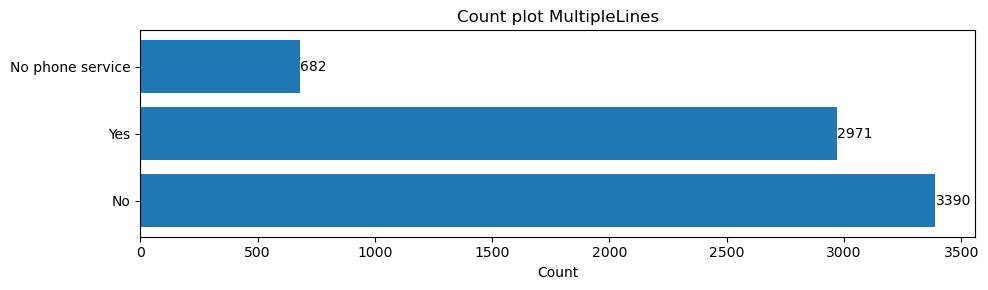

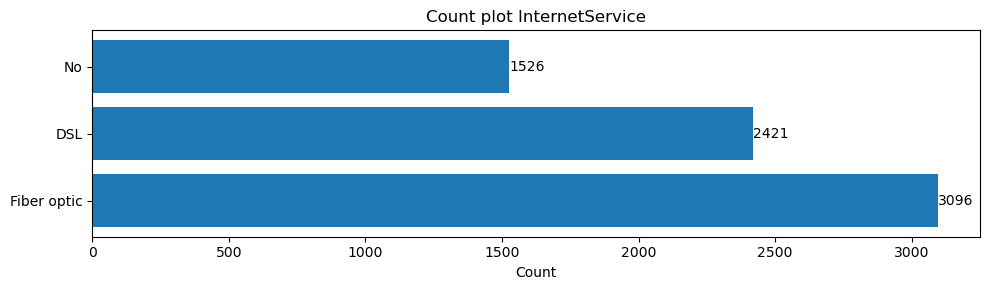

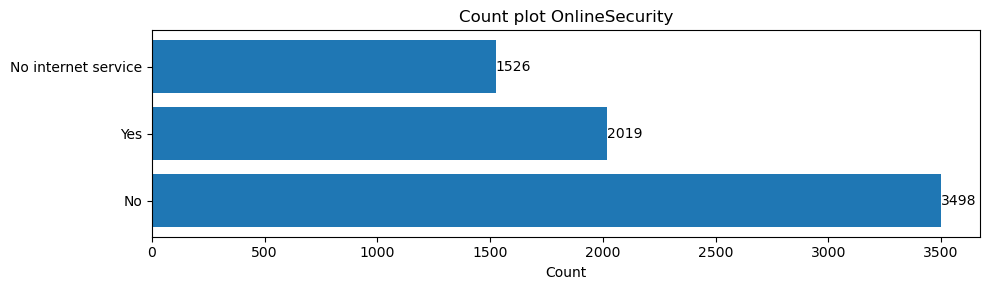

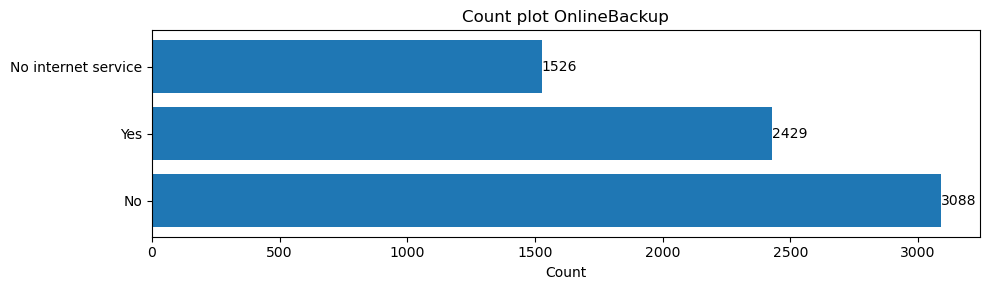

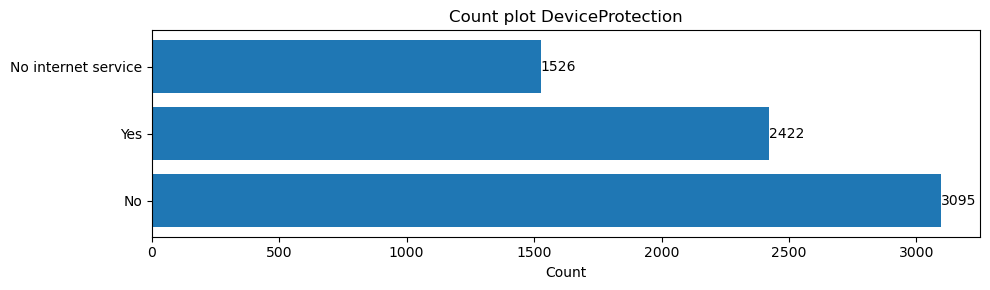

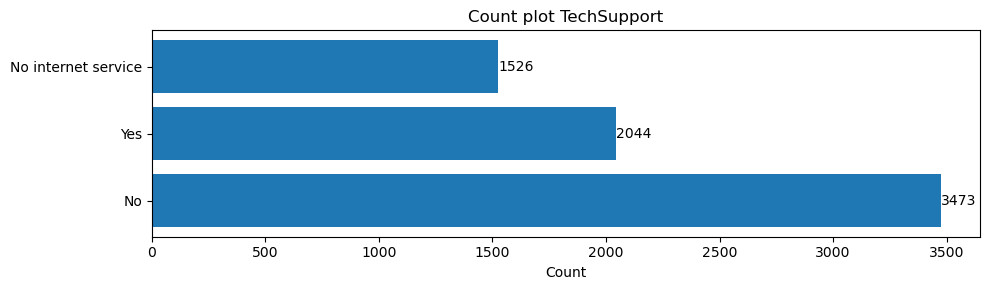

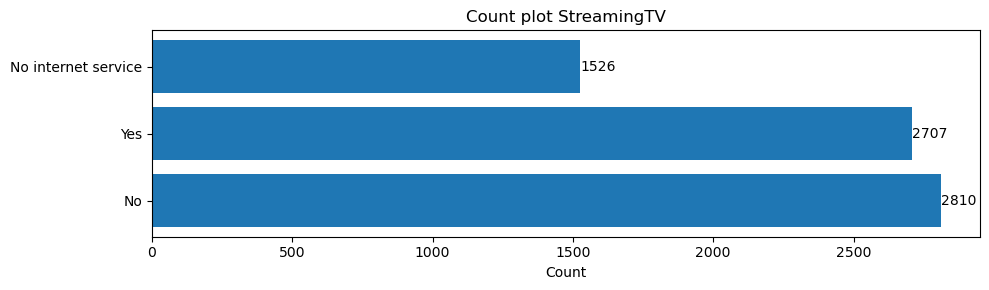

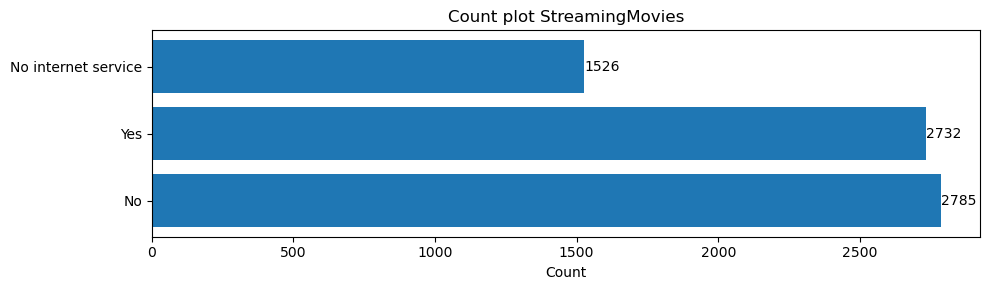

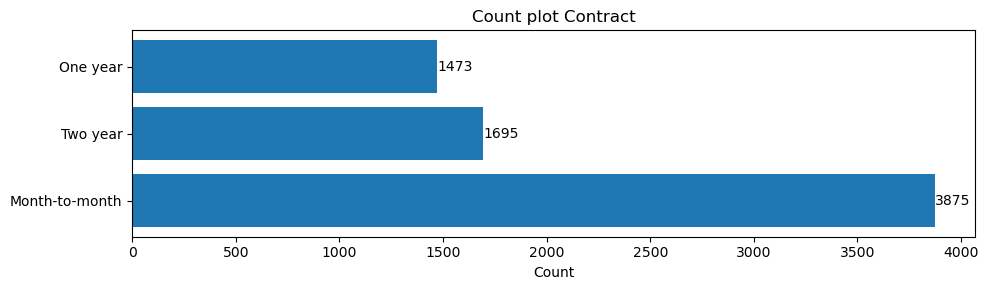

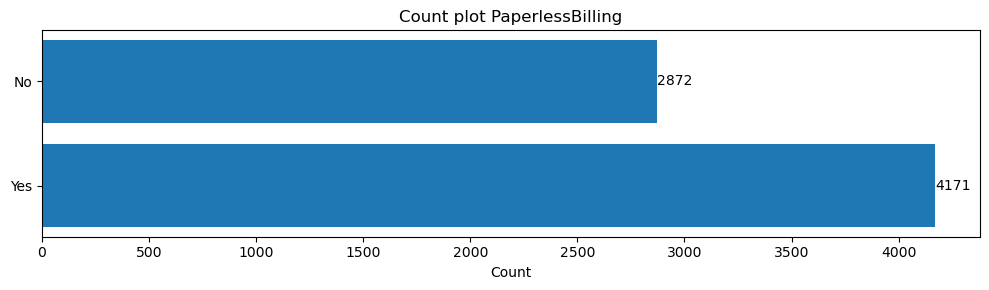

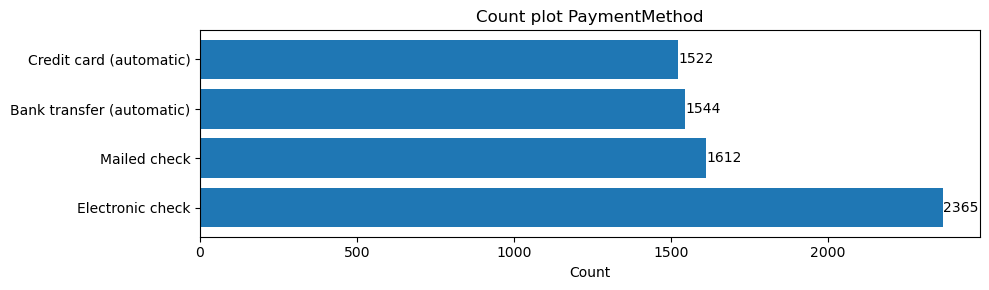

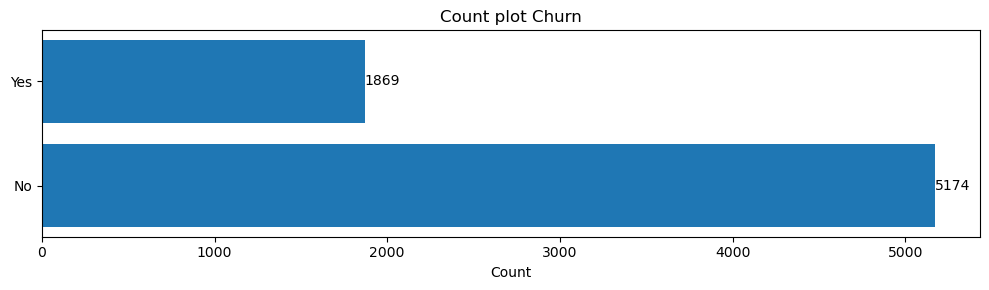

In [12]:
for i in categorical_cols:
    counts = df[i].value_counts()

    plt.figure(figsize = (10, 3))
    bars = plt.barh(counts.index, counts.values)
    plt.title(f"Count plot {i}")
    plt.xlabel("Count")
    for bar in bars:
        width = bar.get_width()
        plt.text(
            x = width,
            y = bar.get_y() + bar.get_height() / 2,
            s = str(width),
            va = 'center'
        )
    plt.tight_layout()
    plt.show()

## 7. Data Preprocessing

In [13]:
try:
    map_binary = {"No": 0, "Yes": 1}
    df['Churn'] = df['Churn'].map(map_binary)       # Mapping target column
    object_cols = df.select_dtypes(include = "object").columns
    encoders = {}

    # Encoding categorical column with LabelEncoder
    # Storing encoders for application prediction
    for i in object_cols:
        label_encoder = LabelEncoder()
        df[i] = label_encoder.fit_transform(df[i])
        encoders[i] = label_encoder

    with open (encoder_dump, "wb") as f:
        pickle.dump(encoders, f)                    # Saving encoders for application prediction
except Exception as e:
    logging.error(f"Failed to preprocess data: {e}")
finally:
    logging.info("Dataset preprocessing completed")

INFO: Dataset preprocessing completed


Preparing data for training

In [14]:
X = df.drop('Churn', axis = 1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
logging.info("Data splitting and oversampling process completed")

INFO: Data splitting and oversampling process completed


## 8. Training the model

In [15]:
best_score = -float("inf")
model = None

# Define candidate models with SMOTE integrated into pipelines
# Comment the models which are not to be considered for model selection
models_config = {
    "XGBClassifier": {
        "estimator": Pipeline(steps = [
            ("smote", SMOTE(random_state = 42)),
            ("clf", xgb.XGBClassifier(
                eval_metric = "auc",
                random_state = 42,
                tree_method = "hist",
                n_jobs = -1
            ))
        ]),
        "params": {
            "clf__n_estimators": [100, 200, 300, 400, 500],
            "clf__max_depth": [3, 4, 5, 6, 7],
            "clf__learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
            "clf__subsample": [0.6, 0.7, 0.8, 0.9],
            "clf__colsample_bytree": [0.6, 0.7, 0.8, 0.9],
            "clf__min_child_weight": [1, 3, 5, 7],
            "clf__gamma": [0, 0.1, 0.3, 0.5],
            "clf__reg_alpha": [0.1, 0.5, 1.0],
            "clf__reg_lambda": [0.1, 0.5, 1.0]
        }
    },

    "LogisticRegression": {
        "estimator": Pipeline(steps = [
            ("smote", SMOTE(random_state = 42)),
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                max_iter = 5000,
                solver = "saga"
            ))
        ]),
        "params": {
            "clf__C": np.logspace(-4, 3, 40),
            "clf__penalty": ["l1", "l2"]
        }
    },

    "SVC": {
        "estimator": Pipeline(steps = [
            ("smote", SMOTE(random_state = 42)),
            ("scaler", StandardScaler()),
            ("clf", SVC(
                kernel = "rbf",
                probability = True,
                random_state = 42
            ))
        ]),
        "params": {
            "clf__C": np.logspace(-2, 2, 10),
            "clf__degree": [2, 3, 4],
            "clf__gamma": ["scale", "auto"]
        }
    },

    "DecisionTree": {
        "estimator": Pipeline(steps = [
            ("smote", SMOTE(random_state = 42)),
            ("clf", DecisionTreeClassifier(
                random_state = 42
            ))
        ]),
        "params": {
            "clf__max_depth": [3, 4, 5, 6, 7],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [5, 10, 20, 50],
            "clf__max_features" : [None, "sqrt", "log2", 0.3, 0.5],
            "clf__criterion": ["log_loss", "gini", "entropy"]
        }
    },

    "RandomForest": {
        "estimator": Pipeline(steps = [
            ("smote", SMOTE(random_state = 42)),
            ("clf", RandomForestClassifier(
                random_state = 42,
                n_jobs = -1
            ))
        ]),
        "params": {
            "clf__n_estimators": [300, 500, 800, 1200],
            "clf__max_depth": [5, 8, 12, 16],
            "clf__min_samples_split": [10, 20, 50],
            "clf__min_samples_leaf": [5, 10, 20, 50],
            "clf__max_features": ["sqrt", "log2", 0.3, 0.5],
            "clf__bootstrap": [True, False]
        }
    }
}

# Model-specific RandomizedSearch iteration counts
n_iter_map = {
    "RandomForest": 80,
    "XGBClassifier": 60,
    "SVC": 60,
    "LogisticRegression": 40,
    "DecisionTree": 25
}

# Train and evaluate each model using cross-validation
for model_name, config in models_config.items():
    logging.info(f"Training {model_name}")

    search = RandomizedSearchCV(
        estimator = config["estimator"],
        param_distributions = config["params"],
        n_iter = n_iter_map.get(model_name, 25),
        scoring = "roc_auc",
        cv = 5,
        random_state = 42,
        n_jobs = -1
    )
    search.fit(X = X_train, y = y_train)
    logging.info(f"{model_name} best CV ROC-AUC: {search.best_score_:.4f}")

    # Select model with highest cross-validation ROC-AUC
    if search.best_score_ > best_score:
        model = search.best_estimator_
        best_score = search.best_score_

if hasattr(model, "named_steps"):
    state_holder["model_name"] = model.named_steps["clf"].__class__.__name__
else:
    state_holder["model_name"] = model.__class__.__name__

state_holder["model_parameters"] = model.get_params()
logging.info(f"Selected model: {state_holder["model_name"]} with CV ROC-AUC: {best_score:.4f}")

INFO: Training XGBClassifier
INFO: XGBClassifier best CV ROC-AUC: 0.8394
INFO: Training LogisticRegression
INFO: LogisticRegression best CV ROC-AUC: 0.8288
INFO: Training SVC
INFO: SVC best CV ROC-AUC: 0.8214
INFO: Training DecisionTree
INFO: DecisionTree best CV ROC-AUC: 0.8187
INFO: Training RandomForest
INFO: RandomForest best CV ROC-AUC: 0.8386
INFO: Selected model: XGBClassifier with CV ROC-AUC: 0.8394


Saving the model for later use

In [16]:
joblib.dump(model, model_dump)
logging.info('Model saved successfully')

INFO: Model saved successfully


## 9. Analysis of Model

Classification Report

In [17]:
# Compute classification report
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
classification_report = classification_report(y_test, y_pred, output_dict = True)
classification_report_df = pd.DataFrame.from_dict(classification_report)

# Store classification report dataframe 
state_holder["model_classification_report"] = classification_report_df

# Visualize classification report
print("Classification Report: \n")
classification_report_df

Classification Report: 



,0,1,accuracy,macro avg,weighted avg
precision,0.882932,0.539394,0.762243,0.711163,0.791745
recall,0.779710,0.713904,0.762243,0.746807,0.762243
f1-score,0.828117,0.614499,0.762243,0.721308,0.771415
support,1035.000000,374.000000,0.762243,1409.000000,1409.000000


Confusion Matrix

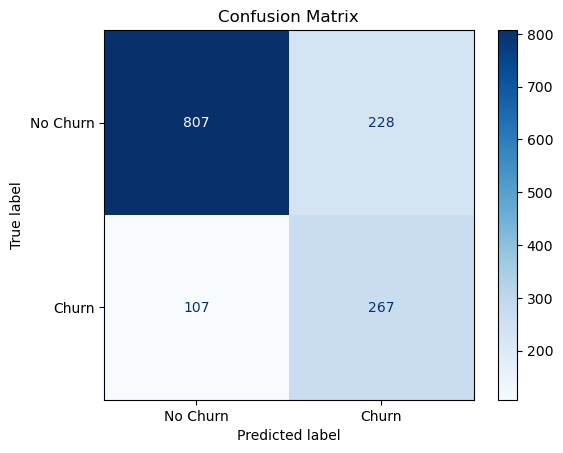

In [18]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Store confusion matrix for dashboard report
state_holder["model_confusion_matrix"] = cm

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels = ['No Churn', 'Churn'])
disp.plot(cmap = 'Blues')
plt.title("Confusion Matrix")
plt.show()

ROC-AUC Curve

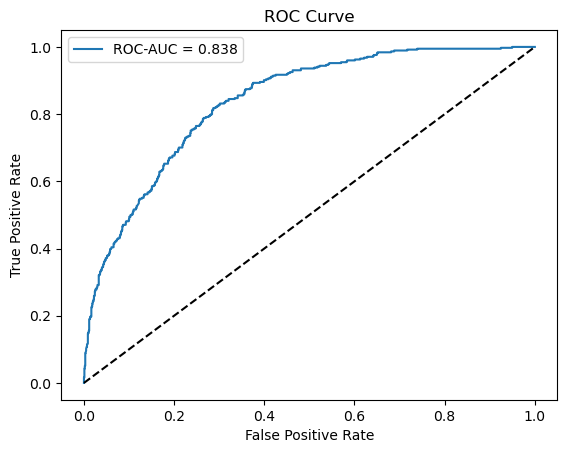

In [19]:
# Compute false positive ratio and true positive ratio corresponding to decision threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate area under ROC Curve
roc_auc = auc(fpr, tpr)

# Store FPR, TPR and ROC-AUC for dashboard report
state_holder["model_fpr_tpr_auc"] = (fpr, tpr, roc_auc)

# Visualize ROC curve against random classifier baseline
plt.plot(fpr, tpr, label = f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Precision Recall Curve

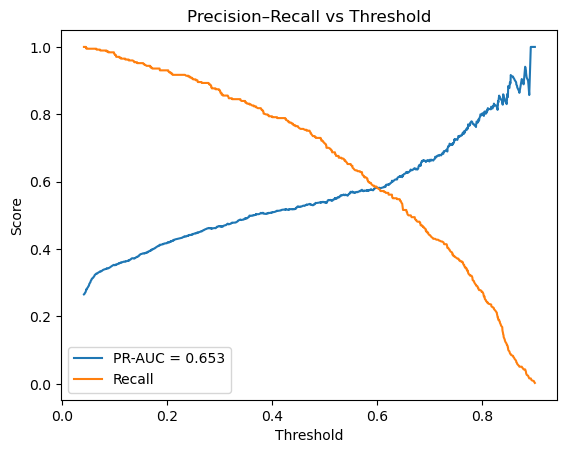

In [20]:
# Compute precision, recall, and corresponding decision thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate area under the Precision–Recall curve
pr_auc = auc(recall, precision)

# Store precision–recall data and PR-AUC for dashboard report
state_holder["model_precision_recall_prauc"] = (precision, recall, thresholds, pr_auc)

# Visualize precision-recall vs decision threshold
plt.plot(thresholds, precision[:-1], label = f"PR-AUC = {pr_auc:.3f}")
plt.plot(thresholds, recall[:-1], label = 'Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision–Recall vs Threshold')
plt.show()

Feature Importance Plot

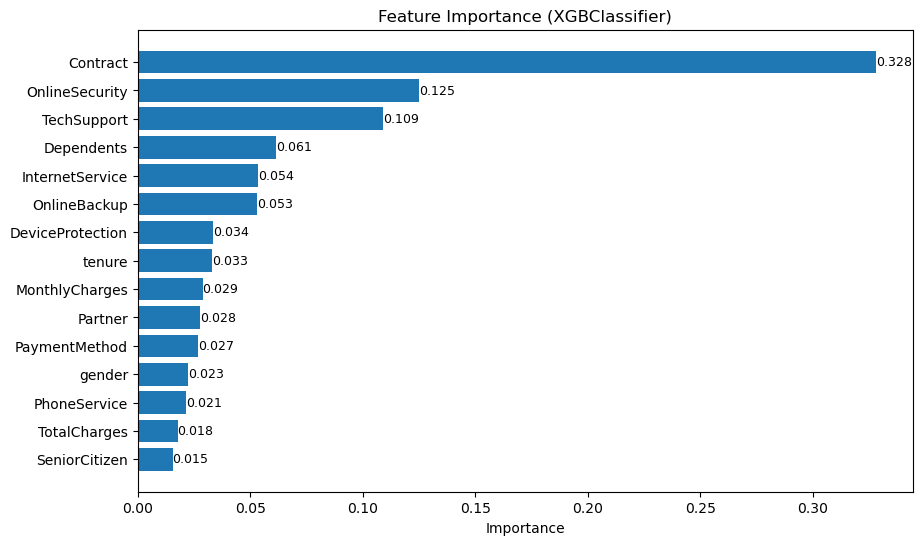

In [21]:
def get_feature_importance(model, X, y = None, feature_names = None, method = "auto", n_repeats = 10, random_state = 42):
    if feature_names is None:
        feature_names = X.columns

    if hasattr(model, "named_steps"):
        clf = model.named_steps["clf"]
    else:
        clf = model

    if method == "auto" and hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
    elif method == "auto" and hasattr(clf, "coef_"):
        importances = np.abs(clf.coef_).ravel()
    else:
        if y is None:
            raise ValueError("y must be provided for permutation importance")
        result = permutation_importance(
            model = model,
            X = X,
            y = y,
            n_repeats = n_repeats,
            scoring = "roc_auc",
            random_state = random_state,
            n_jobs = -1
        )
        importances = result.importances_mean

    feature_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by = "Importance", ascending = False)
    return feature_df

def plot_feature_importance(feature_df, top_n = 15, title = "Feature Importance", value_fmt = "{:.3f}"):
    fig, ax = plt.subplots(figsize = (10, 6))
    plot_df = feature_df.head(top_n).iloc[::-1]
    ax.set_title(title)
    ax.set_xlabel("Importance")
    ax.set_ylabel("")
    bars = ax.barh(y = plot_df["Feature"], width = plot_df["Importance"])
    for bar in bars:
        width = bar.get_width()
        ax.text(
            x = width,
            y = bar.get_y() + bar.get_height() / 2,
            s = value_fmt.format(width),
            va = "center",
            ha = "left",
            fontsize = 9
        ) 
    return fig

# Compute feature importance
feature_df = get_feature_importance(
    model = model,
    X = X_test,
    y = y_test,
    feature_names = X_test.columns
)

# Store feature importance dataframe for dashboard report
state_holder["feature_importance_dataframe"] = feature_df

# Visualize feature importance
fig = plot_feature_importance(
    feature_df = feature_df,
    title = f"Feature Importance ({state_holder['model_name']})"
)
plt.show()

Cross Validation Score

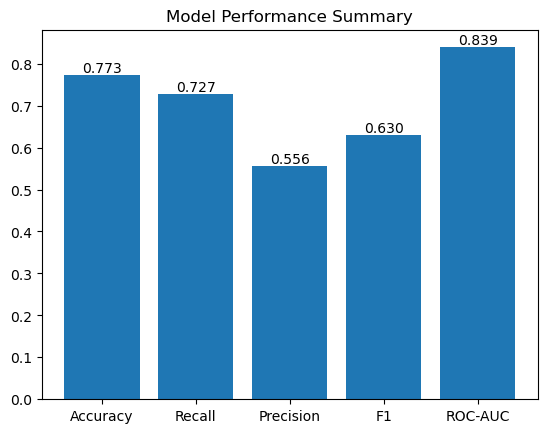

In [22]:
# Compute key cross validation metrics to evaluate model performance
# Mean scores across folds are used for stable evaluation
cv_scores = {
    "Accuracy" : cross_val_score(model, X_train, y_train, cv = 5, scoring = "accuracy").mean(),
    "Recall" : cross_val_score(model, X_train, y_train, cv = 5, scoring = "recall").mean(),
    "Precision" : cross_val_score(model, X_train, y_train, cv = 5, scoring = "precision").mean(),
    "F1" : cross_val_score(model, X_train, y_train, cv = 5, scoring = "f1").mean(),
    "ROC-AUC" : cross_val_score(model, X_train, y_train, cv = 5, scoring = "roc_auc").mean()
}

# Store cross validation metrics for dashboard report
state_holder["model_cv_scores"] = cv_scores

# Visualize cross validation metrics
bars = plt.bar(x = cv_scores.keys(), height = cv_scores.values())
plt.title('Model Performance Summary')
for bar in bars:
    height = bar.get_height()
    plt.text(
        x = bar.get_x() + bar.get_width() / 2,
        y = height,
        s = f'{height:.3f}',
        ha = 'center',
        va = 'bottom'
    )
plt.show()

Model Performance Summary

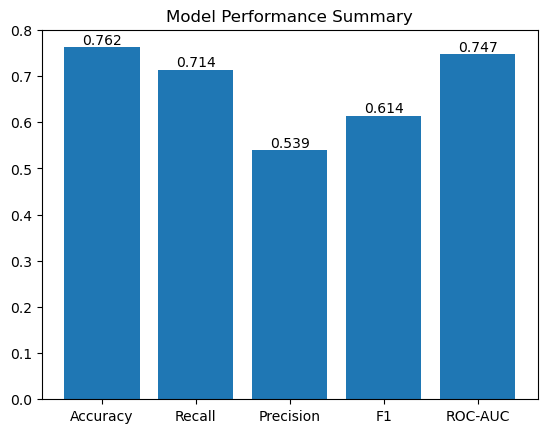

In [23]:
# Compute key classification metrics to evaluate model performance
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred)
}

# Store evaluation metrics for dashboard report
state_holder["model_metrics"] = metrics

# Visualize model performance metrics
bars = plt.bar(x = metrics.keys(), height = metrics.values())
plt.title('Model Performance Summary')
for bar in bars:
    height = bar.get_height()
    plt.text(
        x = bar.get_x() + bar.get_width() / 2,
        y = height,
        s = f'{height:.3f}',
        ha = 'center',
        va = 'bottom'
    )
plt.show()

# 10. Business Impact Analysis and Retention Strategy

Churn Probability Analysis

In [24]:
# Generate churn probabilities for all customers
churn_proba = model.predict_proba(X)[:, 1]

# Create an impact analysis dataframe for business insights
impact_df = df1.copy()
impact_df["Churn Probability"] = churn_proba

# Rank customers by churn risk (highest risk first)
impact_df = impact_df.sort_values(
    by = "Churn Probability",
    ascending = False
).reset_index(drop = True)

# Store impact dataframe for analysis and dashboard visualization
state_holder["impact_df"] = impact_df

Risk Segment and Revenue at Risk

In [25]:
# Categorize customers into churn risk segments based on predicted probability
def risk_bucket(prob):
    if prob > 0.7:
        return "High Risk"
    elif prob >= 0.4:
        return "Medium Risk"
    else:
        return "Low Risk"
    
# Assign risk segments to each customer
impact_df["Risk Segment"] = impact_df["Churn Probability"].apply(risk_bucket)

# Calculating annual revenue at risk assuming potential churn within next year
impact_df["Revenue at Risk"] = impact_df["MonthlyCharges"] * 12

# Aggregate churn risk and revenue impact at segment level
impact_summary = (
    impact_df
    .groupby("Risk Segment")
    .agg(
        Customer_Count = ("customerID", "count"),
        Avg_Churn_Probability = ("Churn Probability", "mean"),
        Total_Revenue_At_Risk = ("Revenue at Risk", "sum")
    )
    .reset_index()
).sort_values(by = "Total_Revenue_At_Risk").reset_index(drop = True)
state_holder["impact_summary"] = impact_summary
impact_summary

,Risk Segment,Customer_Count,Avg_Churn_Probability,Total_Revenue_At_Risk
0,High Risk,1244,0.796057,1145839.2
1,Medium Risk,1690,0.558371,1436038.2
2,Low Risk,4109,0.150648,2891521.8


Retention Stimulation, Customer Distribution with Risk Segment and Total Revenue at Risk in each segment

<Axes: title={'center': 'Revenue at Risk by Churn Segment'}, xlabel='Risk Segment'>

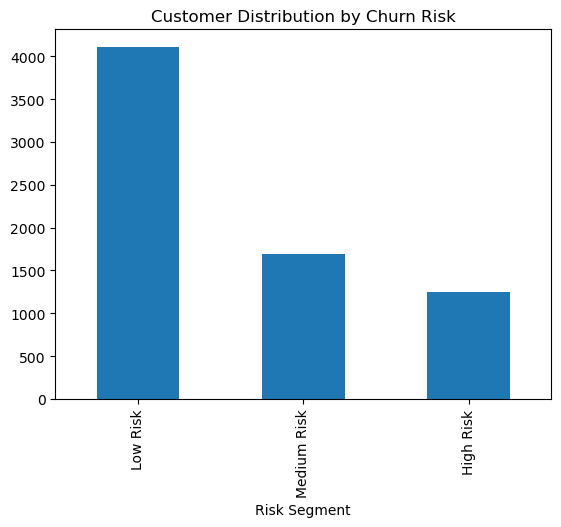

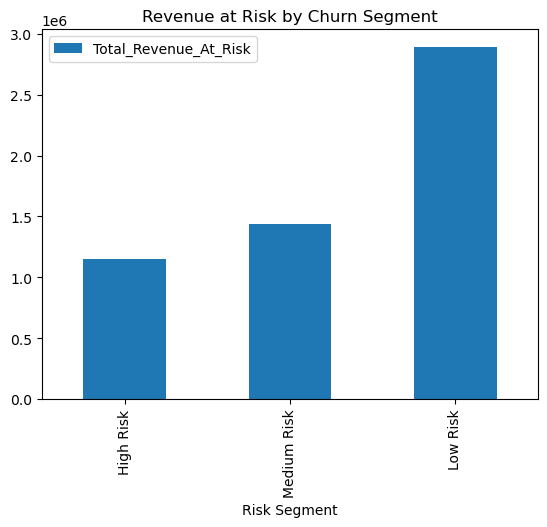

In [26]:
# Identify top 10% highest-risk customers based on churn probability
top_10_pct = int(0.10 * len(impact_df))
target_customers = impact_df.head(top_10_pct)

# Assumed retention success rate for targeted intervention campaigns
retention_rate = 0.30

# Estimate revenue that could be retained by focusing on high-risk customers
estimated_saved_revenue = (
    target_customers["Revenue at Risk"].sum() * retention_rate
)

# Visualize customer distribution across churn risk segments
impact_df["Risk Segment"].value_counts().plot(
    kind = "bar",
    title = "Customer Distribution by Churn Risk"
)

# Visualize revenue exposure by churn risk segment
impact_summary.plot(
    x = "Risk Segment",
    y = "Total_Revenue_At_Risk",
    kind = "bar",
    title = "Revenue at Risk by Churn Segment"
)

Customers were ranked by predicted churn probability and segmented into High, Medium, and Low risk groups.
The High-Risk segment represents a disproportionately large share of revenue at risk.

In [27]:
print(f"A simulated retention campaign targeting the top 10% highest-risk customers could potentially recover approximately ₹{estimated_saved_revenue} monthly revenue.\nAssuming a 30% retention success rate.")

A simulated retention campaign targeting the top 10% highest-risk customers could potentially recover approximately ₹197067.78 monthly revenue.
Assuming a 30% retention success rate.


In [28]:
# Saving state_holder for application

with open(state_dump, "wb") as f:
    pickle.dump(state_holder, f)
logging.info("State Backup generation complete")

INFO: State Backup generation complete
